# 21M.387 Fundamentals of Music Processing
## Chromagrams


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact
import IPython.display as ipd

import sys
sys.path.append("../common")
from util import *
import fmp

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

## Reading

Chapters 3.0 - 3.1 (pp 115 – 130), 7.2.1 (pp 374 – 376)

<img src="images/book_cover.png" width=200>

We now move from a `low-level` to a `mid-level` feature representation.

- low level: close to the raw audio.
- mid level: some data reduction, focusing the feature space on a more specific task.

We will learn about _chromagrams_, which capture the pitch-content and harmonic content of a signal. Chromagrams are:
- insensitive to octave
- insensitive to timbre
- they are also a model more closely related to how the ear hears pitch.

Chromagrams begin with the Spectrogram of the STFT, $\lvert \mathcal{X} (n,k) \rvert^2$, for $x(n)$.

We hear pitch proportional to the logarithm of frequency. But the STFT is linear in frequency.

This is an audio sample of a piano playing a chromatic scale, from the lowest to the highest note.

In [2]:
x = load_wav("audio/piano_chromatic.wav")
fs = 22050
ipd.Audio(x, rate=fs)

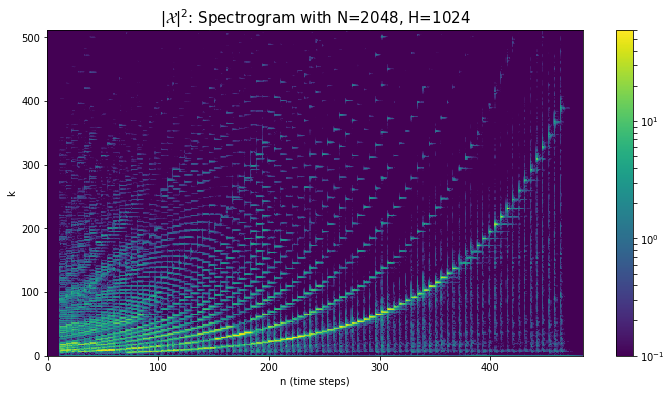

In [3]:
win_len = 2048
hop_size = win_len / 2

spec = fmp.stft_mag(x, win_len, hop_size)

plt.figure()

plot_spectrogram(spec)
plt.ylim(0,spec.shape[0]/2)
plt.title("$|\mathcal{X}|^2$: Spectrogram with N=%d, H=%d" % (win_len, hop_size), fontsize=15)
plt.xlabel("n (time steps)")
plt.ylabel("k")
plt.show()

Here are the frequency locations of the pitch classes on the spectrogram

In [4]:
def pitch_class_name(pc) :
    return ('C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B')[pc]

def plot_spec_with_pitchclass(spec, fs, pc):
    N = 2 * (spec.shape[0] - 1)
    pitches = pc + 36 + np.arange(6) * 12
    freqs = fmp.pitch_to_freq(pitches)
    ks = freqs * N / fs
    plot_spectrogram(spec)
    plt.xlabel("n (time steps)")
    plt.ylabel("k")
    ytop = spec.shape[0]/2
    plt.ylim(0, ytop)
    plt.hlines(ks, 0, spec.shape[1], 'r', linewidth=2)
    txt = 'pitch class:' + pitch_class_name(pc)
    plt.text(0, ytop-30, txt , fontsize=20, color='yellow')

@interact(pc=(0,11))
def _pswp(pc = 0):
    plt.figure()
    plot_spec_with_pitchclass(spec, fs, pc)
    plt.show()

interactive(children=(IntSlider(value=0, description=u'pc', max=11), Output()), _dom_classes=('widget-interact',))

Our first goal is to convert this Spectrogram into a _log-frequency spectrogram_. Or what I call a pitch-o-gram.

How do we do that?

We figure which bins in the Spectrogram contribute to a particular pitch!

For example: A4, p=69.  
We look $\pm 0.5$ around that pitch: $[68.5, 69.5]$

In [5]:
p = 69
print 'Center      pitch:%.1f frequency = %.2f' % (p, fmp.pitch_to_freq(p))
print 'Lower Bound pitch:%.1f frequency = %.2f' % (p - .5, fmp.pitch_to_freq(p - .5))
print 'Upper Bound pitch:%.1f frequency = %.2f' % (p + .5, fmp.pitch_to_freq(p + .5))

Center      pitch:69.0 frequency = 440.00
Lower Bound pitch:68.5 frequency = 427.47
Upper Bound pitch:69.5 frequency = 452.89


So the pitch 69 spans from 427.47Hz to 452.89Hz.

Which bins of the Spectrogram does that correspond to?  
This depends on $N$ and $F_s$:

$$ f = k \cdot {F_s \over N} $$

Lets try $N=2048$ and $F_s = 22050$.


In [6]:
N = 2048
fs = 22050
bins = np.arange(N/2 + 1)
freqs = bins * float(fs) / N
for k in bins[35:50]:
    print "k=%3d   f= %.2f" % (k, freqs[k])

k= 35   f= 376.83
k= 36   f= 387.60
k= 37   f= 398.36
k= 38   f= 409.13
k= 39   f= 419.90
k= 40   f= 430.66
k= 41   f= 441.43
k= 42   f= 452.20
k= 43   f= 462.96
k= 44   f= 473.73
k= 45   f= 484.50
k= 46   f= 495.26
k= 47   f= 506.03
k= 48   f= 516.80
k= 49   f= 527.56


Bins $\{40, 41, 42\}$ contribute to pitch 69.

For $\lvert X(k) \lvert^2$ (single column of the Spectrogram), we can formulate this operation of "picking up the contributions" from bins $\{40, 41, 42\}$ as a dot product of 2 vectors:

$$ p_{69} = \langle C_{69}, \lvert X(k) \lvert^2 \rangle $$

where:

$$
C_{69}(n) = 
\begin{cases}
1 &\text{for  } n \in \{40, 41, 42\} \\
0 &\text{otherwise}
\end{cases}
$$

We can now make a table that assigns some set of bins to a particular pitch by repeating the above process for all pitches.

Express the Spectrogram $\lvert \mathcal{X}(n,k) \rvert^2$ as the matrix $\mathbf{X}$.

The linear algebra way of thinking about this is to create a filter bank, or conversion matrix $\mathbf{C}_{fp}$ that, when multiplied with the spectrogram $\mathbf{X}$ will produce the pitch-o-gram $\mathbf{P}$:

$$\mathbf{P} = \mathbf{C}_{fp} \cdot \mathbf{X}$$

Assume the following constants:

- $M$ is the length of the spectrogram (number of "hops")  
- $K$ is the number of frequency bins. $K = 1 + N/2$.  
- $P$ is the number of midi pitches. $P = 128$.

$\mathbf{X} \text{ is a } K \times M$ matrix  
$\mathbf{P} \text{ is a } P \times M$ matrix  
$\mathbf{C}_{fp} \text{ must be a } P \times K$ matrix  

And it looks like this:

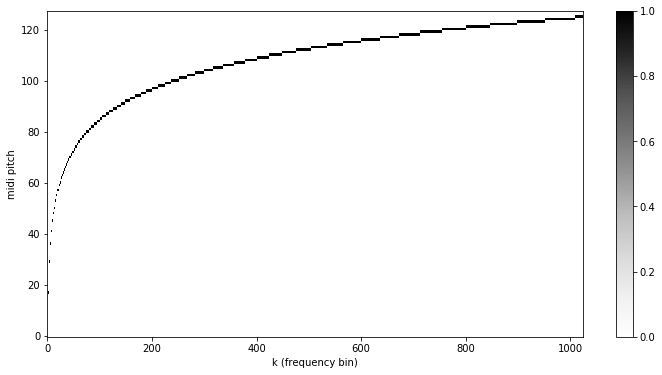

In [7]:
c_fp = fmp.spec_to_pitch_fb(fs, N)
plt.imshow(c_fp, origin='lower', aspect='auto', cmap='Greys')
plt.xlabel("k (frequency bin)")
plt.ylabel("midi pitch")
plt.colorbar();

We can zoom in on a few pitches. For example: p = 69, p = 70, p = 71:

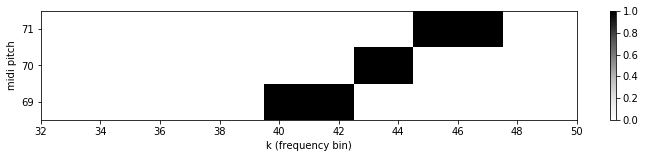

In [8]:
plt.figure(figsize=(12, 2))
plt.imshow(c_fp, origin='lower', aspect='auto', cmap='Greys')
plt.xlim(32, 50)
plt.ylim(68.5, 71.5)
plt.xlabel("k (frequency bin)")
plt.ylabel("midi pitch")
plt.colorbar();

This works fine for high frequencies. Lots of bins contribute to one note. But we have a problem with low notes.

Some notes fall "in between the gaps"


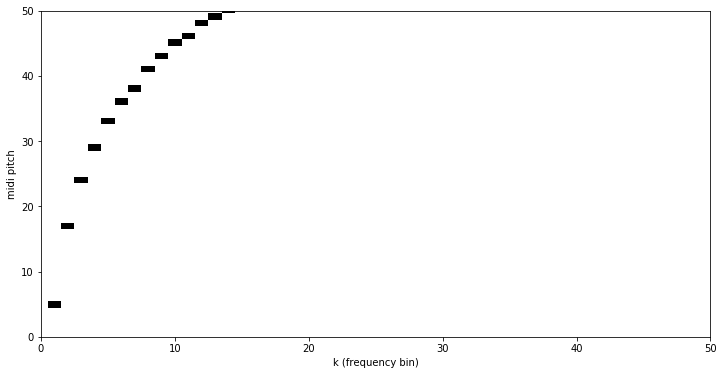

In [9]:
plt.figure()
plt.imshow(c_fp, origin='lower', aspect='auto', cmap='Greys')
plt.xlabel("k (frequency bin)")
plt.ylabel("midi pitch")
plt.ylim(0, 50)
plt.xlim(0, 50);

The Solution: increase $N$.

In [10]:
@interact(ni = (0, 3))
def cfp_n(ni = 0) :
    N = (2048, 4096, 8192, 8192*2)[ni]
    c_fp = fmp.spec_to_pitch_fb(fs, N)
    plt.figure()
    plt.imshow(c_fp, origin='lower', aspect='auto', cmap='Greys')
    plt.xlabel("k (frequency bin)")
    plt.ylabel("midi pitch")
    plt.ylim(0, 60)
    plt.xlim(0, 60)
    txt = 'N=%d' % N
    plt.text(0, 45, txt, fontsize=20)
    plt.show()

interactive(children=(IntSlider(value=0, description=u'ni', max=3), Output()), _dom_classes=('widget-interact',))

There are two ways to increase $N$:
- zero pad the signal to increase the DFT window without increasing the sampling window
- increase the sampling window

Let's try the first.

Here is a low piano note: C2 (pitch = 36)

In [11]:
snd = load_wav('audio/piano_c1.wav')
print 'len =', len(snd)
ipd.Audio(snd, rate=fs)

len = 40960


Begin with 2048 samples of audio (~93 milliseconds).

Use zero padding to increase $N$:

In [12]:
def test_increase_N(x, zpf, pitches) :
    N = len(x)
    N *= zpf
    x_zp = np.concatenate((x* np.hanning(len(x)), np.zeros(N - len(x))))
    plt.figure()
    xl = N/120
    mag_ft = abs(np.fft.rfft(x_zp))[:xl]
    yl = np.max(mag_ft)
    plt.plot(mag_ft, 'bo')
    plt.plot(mag_ft)
    plt.xlim(0, xl)
    plt.title('N=%d (x len=%d + zp=%d)' %(N, len(x), N - len(x)))
    c = 0
    for p in pitches:
        bins = fmp.bins_of_pitch(p, fs, N)
        if len(bins):
            b = bins[0]
            plt.text(b, yl*.6 + c%2, str(p), fontsize=10)
            c += 1
            for b in bins:
                plt.vlines(b, 0, yl * .6, 'r')
    plt.show()

# start a bit after the attack:
n1 = 10000
pitches = (34, 35, 36, 37, 38)

# try different zero pad values:
@interact(zi = (0,3))
def test_zp(zi=0):
    N = 2048
    x = snd[n1:n1+N] * np.hanning(N)    
    test_increase_N(x, 2 ** zi, pitches)

interactive(children=(IntSlider(value=0, description=u'zi', max=3), Output()), _dom_classes=('widget-interact',))

So zero-padding helps only in increasing the frequency resolution. But there is still lots of frequency smearing. 

In [13]:
# now incease N by using a longer window. No zero-pad
@interact(ni = (0,3))
def test_inc_N(ni=0):
    N = 2048 * (2 ** ni)
    x = snd[n1:n1+N] * np.hanning(N)    
    test_increase_N(x, 1, pitches)


interactive(children=(IntSlider(value=0, description=u'ni', max=3), Output()), _dom_classes=('widget-interact',))

A larger window helps much more. There is less smearing, but at the cost of lower time resolution.

$N = 16384$ will requires a window length of $743$ms.

Refinement:

Instead of just a brick-wall for distributing frequency bins to a pitch, use a Gaussian or Hann weighting curve.

For example: Here is $\mathbf{C}_{fp}$ with a Hann window centered around a pitch's center frequency, and falling off to zero at ${\pm 0.5}$.

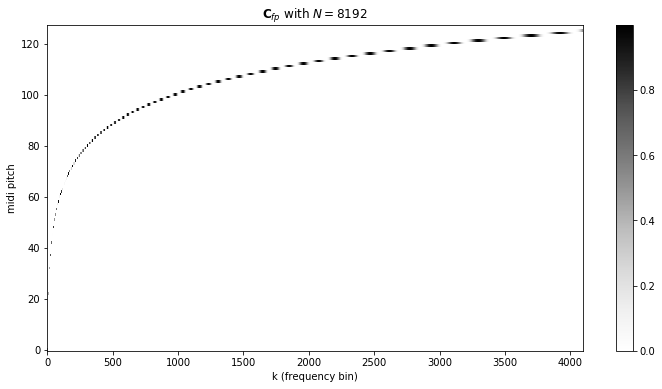

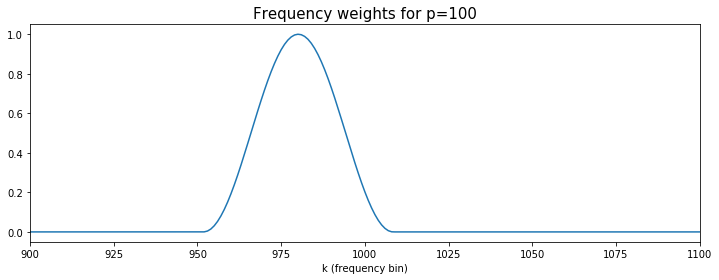

In [14]:
N = 8192
c_fp = fmp.spec_to_pitch_fb(fs, N, type='hann')
plt.figure()
plt.imshow(c_fp, origin='lower', aspect='auto', cmap="Greys")
plt.xlabel("k (frequency bin)")
plt.ylabel("midi pitch")
plt.title("$\mathbf{C}_{fp}$ with $N=%d$" % N)
plt.colorbar();

plt.figure(figsize=(12,4))
plt.plot(c_fp[100,:])
plt.xlim(900, 1100)
plt.title("Frequency weights for p=100", fontsize=15)
plt.xlabel("k (frequency bin)");


It is also very helpful to "tune" $\mathbf{C}_{fp}$ to the particular pitch used in the recording. For example, many orchestras tune A to something other than 440Hz.

Now that we have $\mathbf{C}_{fp}$, let's create the pitch-o-gram:

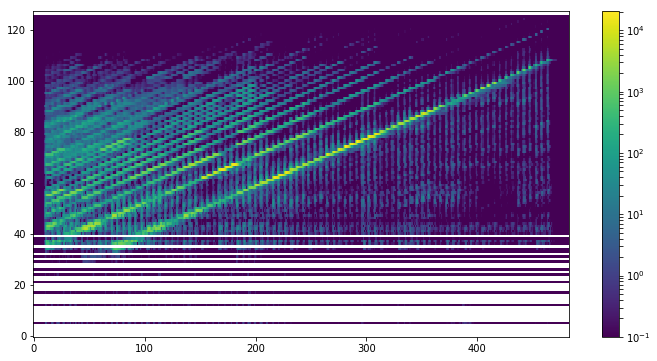

In [15]:
x = load_wav("audio/piano_chromatic.wav")
fs = 22050
fft_len = 4096
hop_size = fft_len / 4

spec = fmp.stft_mag(x, fft_len, hop_size) ** 2
c_fp = fmp.spec_to_pitch_fb(fs, fft_len, type='hann')

pitchogram = np.dot(c_fp, spec)
plt.figure()
plot_spectrogram(pitchogram)

In [16]:
def plot_pitchogram_with_pitchclass(spec, fs, pc):
    N = 2 * (spec.shape[0] - 1)
    pitches = pc + 24 + np.arange(7) * 12
    plot_spectrogram(spec)

    plt.hlines(pitches, 0, spec.shape[1], 'r', linewidth=2)
    txt = 'pitch class:' + pitch_class_name(pc)
    
    plt.text(0, 120, txt , fontsize=20, color='red')

@interact(pc=(0,11))
def _ppwp(pc = 0):
    plt.figure()
    plot_pitchogram_with_pitchclass(pitchogram, fs, pc)
    plt.show()


interactive(children=(IntSlider(value=0, description=u'pc', max=11), Output()), _dom_classes=('widget-interact',))

The next step is to further reduce the feature size by using the principle of octave equivalence. We need to sum all pitches of the pitch-o-gram belonging to the same pitch class.

This can be done with another conversion / filterbank matrix 

A "pitch to chroma" filterbank converts a feature space of length 128 pitches to a feature space of length 12 pitch classes.

$\mathbf{C}_{pc} \text{ is } 12 \times 128$ and looks like this:

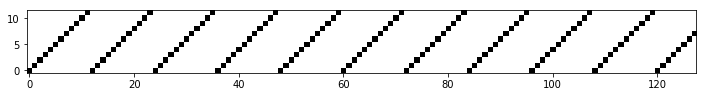

In [17]:
c_pc = np.tile(np.identity(12), 11)[:, 0:128]
plt.figure()
plt.imshow(c_pc, origin='lower', cmap="Greys");

Convert the the pitch-o-gram matrix $\mathbf{P}$ to the chromagram $\mathbf{C}$ with matrix multiplication using the above matrix:

$$\mathbf{C} = \mathbf{C}_{pc} \cdot \mathbf{P} $$

The resulting chromagram for the piano chromatic scale is below

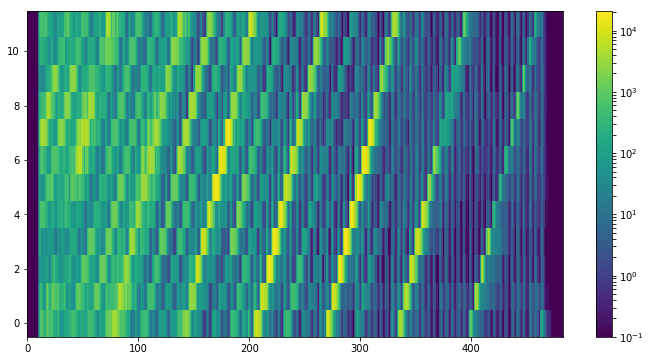

In [18]:
chromagram = np.dot(c_pc, pitchogram)
plt.figure()
plot_spectrogram(chromagram)

Finally, we can combine the two conversion matrices into one. We have:

$$\mathbf{P} = \mathbf{C}_{fp} \cdot \mathbf{X} $$

and

$$\mathbf{C} = \mathbf{C}_{pc} \cdot \mathbf{P} $$

Which means:

$$\mathbf{C} = \mathbf{C}_{pc} \cdot \mathbf{C}_{fp} \cdot \mathbf{X} $$

Since matrix multiplication is associative, we can define:
$$\mathbf{C}_{fc} = \mathbf{C}_{pc} \cdot \mathbf{C}_{fp}$$

which then creates the chromagram in one step:

$$\mathbf{C} = \mathbf{C}_{fc} \cdot \mathbf{X} $$

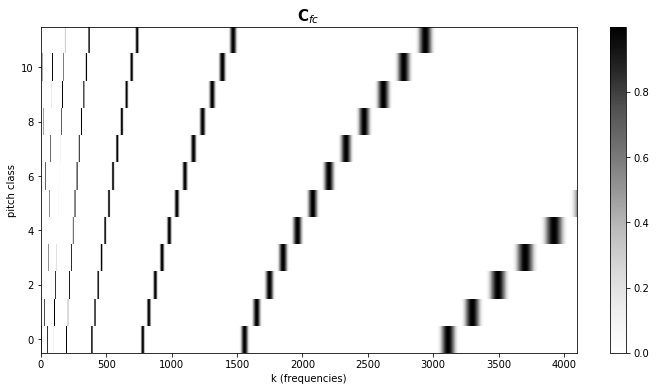

In [19]:
c_fp = fmp.spec_to_pitch_fb(fs, N, type='hann')
c_fc = np.dot(c_pc, c_fp)

plt.figure()
plt.imshow(c_fc, origin='lower', aspect='auto', cmap='Greys');
plt.colorbar()
plt.xlabel('k (frequencies)')
plt.ylabel('pitch class')
plt.title("$\mathbf{C}_{fc}$", fontsize=15);

All the above plots have been log-scale plots. This is what the chromatic chromagram looks like with linear values

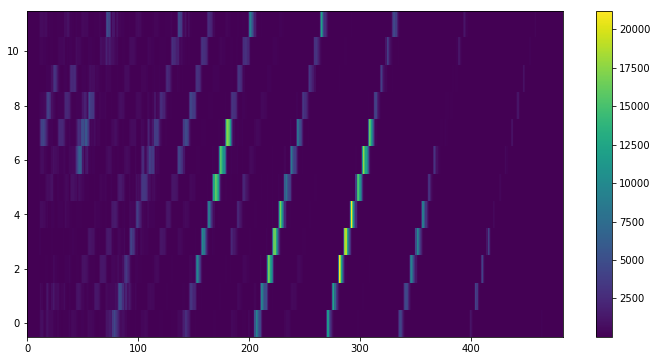

In [20]:
plt.figure()
plt.imshow(chromagram, origin='lower', aspect='auto')
plt.colorbar();

Like we did with Spectrogram, we can improve the chromagram by using logarithmic compression.
This helps bring out energy that our ears hear, but that otherwise would be under-represented in the data.

$\Gamma_\gamma(v) = \log(1+ \gamma \cdot v)$

- $v$ is the value to compress
- $\gamma$ is the compression factor

$\mathcal{C}_\gamma =  \log(1+ \gamma \cdot \mathcal{C})$


In [21]:
snd1 = load_wav("audio/piano_c4.wav")
snd2 = load_wav("audio/violin_c4.wav")

fs = 22050
fft_len = 8192


@interact(gi=(0,4), norm=False)
def chroma_variants(gi=0, norm=False):
    gamma = (0, .1, 1, 10, 100)[gi]
    chroma1 = fmp.make_chromagram(snd1, fs, fft_len, fft_len/2, gamma, norm)
    chroma2 = fmp.make_chromagram(snd2, fs, fft_len, fft_len/2, gamma, norm)

    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(chroma1, origin='lower', aspect='auto', cmap='Greys')
    txt = "$\gamma = %.1f$ %s" % (gamma, ("","normalized")[norm])
    plt.colorbar()
    plt.text(0, 12, txt, fontsize=20)
    plt.subplot(1,2,2)
    plt.imshow(chroma2, origin='lower', aspect='auto', cmap='Greys')
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=0, description=u'gi', max=4), Checkbox(value=False, description=u'norm'), Output()), _dom_classes=('widget-interact',))

In [22]:
ipd.Audio(snd1, rate=fs)

In [23]:
ipd.Audio(snd2, rate=fs+1)

We almost always normalize the chromagram as well:

Each 12-point column vector is normalized with respect to some norm $\Vert \cdot \Vert$. We most often use the _Euclidean norm_ (also called the $L^2$ norm).

For a vector $x$, the Euclidean norm is:

$$\Vert x \Vert = {\langle x , x \rangle}^{1/2}$$

Then, each column vector of the chromagram is replaced with:

$${x \over \Vert x \Vert}$$

This has the effect of making chromagrams invariant to changes in volume. Only the values relative to each other matter.

The _direction_ of the chroma vector remains the same.

Some Examples

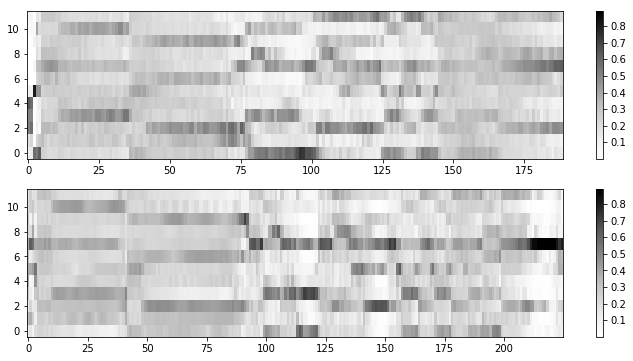

In [24]:
snd1 = load_wav("audio/beeth5_orch_21bars.wav")
snd2 = load_wav("audio/beeth5_piano_21bars.wav")
fs = 22050
fft_len = 4096
hop_size = fft_len / 2

chroma1 = fmp.make_chromagram(snd1, fs, fft_len, hop_size, 10, True)
chroma2 = fmp.make_chromagram(snd2, fs, fft_len, hop_size, 10, True)
plt.figure()
plot_two_chromas(chroma1, chroma2)

In [25]:
ipd.Audio(snd1, rate = fs)

In [26]:
ipd.Audio(snd2, rate = fs)

Another enhancement strategy is to smooth and downsample the chromagrams.

A technique developed by Muller et al is called _CENS_ (Chroma Energy Normalized Statistics). See pages 374-376 in the textbook. It has 5 steps to enhance a standard chormagram:

1. Normalize with a Manhattan Norm (also called $L_1$ norm).
- Logarithmic quantization with a noise floor.
- Smoothing
- Downsampling
- Normalizing again by Euclidean norm

This has several beneficial effects:
- It suppresses "indistinct" vectors (by using the $L_1$ norm).
- It removes noise below a certain level
- It creates "logarithmic-style" compression
- It removes small fluctuations
- It reduces the data rate

In [27]:
@interact(win_len = (1, 21, 2), ds=(1,10))
def cens_variants(win_len=1, ds=1):
    chroma1 = fmp.make_chromagram(snd1, fs, fft_len, hop_size, 0, False)
    chroma1 = fmp.cens(chroma1, win_len, ds)

    chroma2 = fmp.make_chromagram(snd2, fs, fft_len, hop_size, 0, False)
    chroma2 = fmp.cens(chroma2, win_len, ds)

    plt.figure()
    plot_two_chromas(chroma1, chroma2)
    plt.show()

interactive(children=(IntSlider(value=1, description=u'win_len', max=21, min=1, step=2), IntSlider(value=1, description=u'ds', max=10, min=1), Output()), _dom_classes=('widget-interact',))